## A comparative study of neural network and box-Jenkins ARIMA modeling in time series prediction

### By: Zakaria El Founoun

The goal of this notebook is to reproduce the numerical experiments from the paper `A comparative study of neural network and box-Jenkins ARIMA modeling in time series prediction`.

In [197]:
# Importing dependencies 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal

from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error as mse 
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

In [198]:
# Utilities 

def detrend(y, time_axis,d = 2):
    """
    A function to remove trends from the time series y by fitting a polynomial function of degree d on y and returning the subtracted time series 
    """
    coeffs = np.polyfit(time_axis, y, d)
    return coeffs

def fig_ax(figsize=(15, 4), subplots = (1,1)):
    """
    A function to set the size of the figure
    """
    return plt.subplots(*subplots, figsize=figsize)

### First experience: Air Passengers Dataset

In [247]:
# Load Air Passengers Dataset
air_passengers = pd.read_csv("./data/airline-passengers.csv")
air_passengers['Month'] = pd.to_datetime(air_passengers['Month'])
air_passengers.set_index('Month', inplace=True)

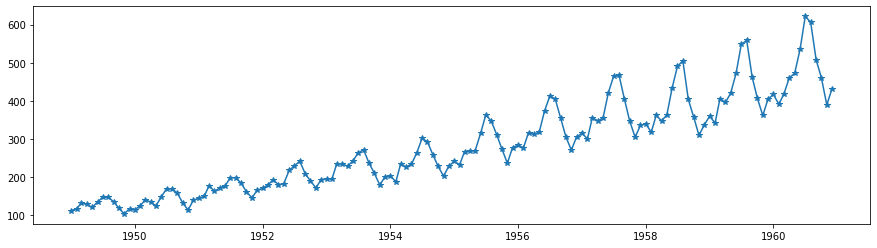

In [200]:
# let's plot the data 
fig, ax = fig_ax()
ax.plot(air_passengers, "*-")
fig.show()

# Data preparation

In [248]:
# Let's keep a copy of the original data untouched 
origine_air_passengers = air_passengers.copy()

In [249]:
# Train test split 
# Should we do the minimax scaler before or after train test split 

splitting_time = '1959' # set the time from which the data is train test splitted
start_test_time = '1960'

# Scalling data 
scaler = StandardScaler().fit(air_passengers[:splitting_time]['Passengers'].values.reshape(-1, 1))
air_passengers['Passengers'] = np.concatenate([scaler.transform(air_passengers[:splitting_time]['Passengers'].values.reshape(-1, 1)).squeeze() , scaler.transform(air_passengers[start_test_time:]['Passengers'].values.reshape(-1, 1) ).squeeze()])

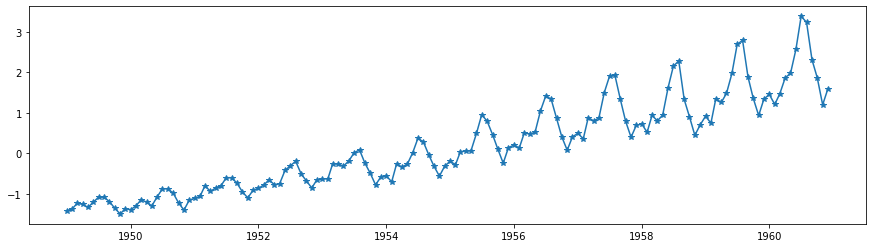

In [203]:
fig, ax = fig_ax()
ax.plot(air_passengers, "*-")
fig.show()

## Box jenkins method 

In [204]:
# In order to remove the trend from the data we are going to fit a polynomial function, whose degree is suitably choosed 


air_passengers_np = air_passengers['Passengers'].values
n_samples_pred = 12  # predict the next 15 samples (~10% of the whole data)
train_time_index , test_time_index =  np.split(np.arange(len(air_passengers)), [-n_samples_pred])

coeffs = detrend(air_passengers_np[train_time_index],train_time_index,d= 2)

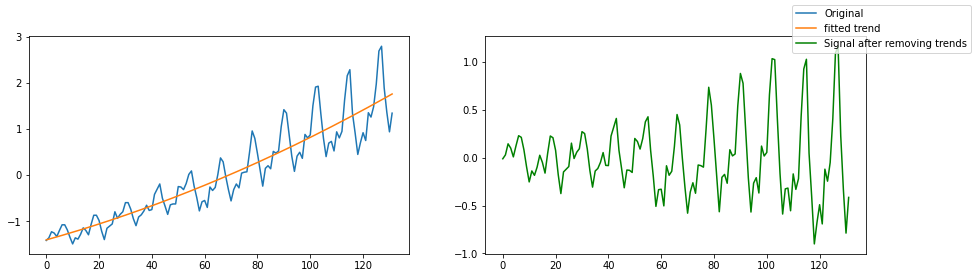

In [205]:
# let's visualize the fitted trend component

# Evaluate the polynomial at the same time points as the original data
y_fit = np.polyval(coeffs, train_time_index)
fig, ax = fig_ax(subplots= (1,2))
ax[0].plot(air_passengers_np[train_time_index], label="Original")

ax[0].plot(y_fit, label="fitted trend")


detrend_signal = air_passengers_np[train_time_index] - y_fit

ax[1].plot(detrend_signal, label="Signal after removing trends", color = 'g')
_ = fig.legend()
fig.show()

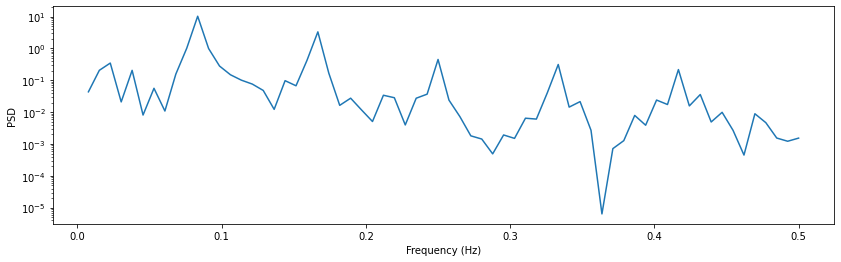

In [207]:
# Next step in our analysis is to look for seasonal components 


# Compute the periodogram
f, Pxx = signal.periodogram(detrend_signal)

# Plot the periodogram
plt.figure(figsize = (14,4))
plt.semilogy(f[1:], Pxx[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

In [208]:
print(f"the estimated main frequency is: {f[np.argmax(Pxx)]} ")

the estimated main frequency is: 0.08333333333333334 


In [209]:
# now let's use this estimated frequency to fit a harmonic regression

f = 0.0833 #0.08527

# let's define and construct our matrix 

beta1 = np.cos(2 * np.pi * f * train_time_index)
beta2 = np.sin(2 * np.pi * f * train_time_index)
beta = np.vstack([beta1, beta2]).T

clf = LinearRegression(fit_intercept= True)
clf.fit(beta, detrend_signal)
coefficients =  clf.coef_
mean = clf.intercept_

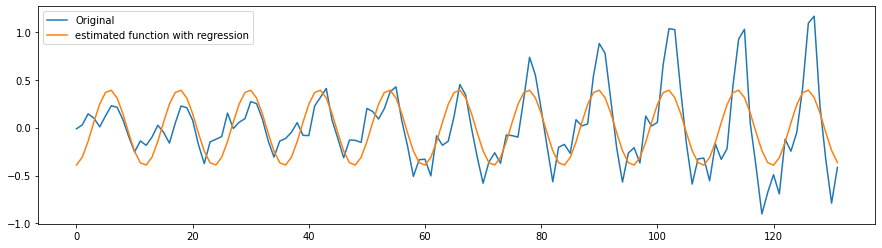

In [210]:
# let's implement the estimated function 
estimated_regression_function = lambda x: mean + coefficients[0] * np.cos(2 * np.pi * f * x) + coefficients[1] * np.sin(2 * np.pi * f * x) 

fig, ax = fig_ax()

ax.plot(train_time_index ,detrend_signal, label="Original")
ax.plot(train_time_index, estimated_regression_function(train_time_index), label=f"estimated function with regression")

_ = plt.legend()

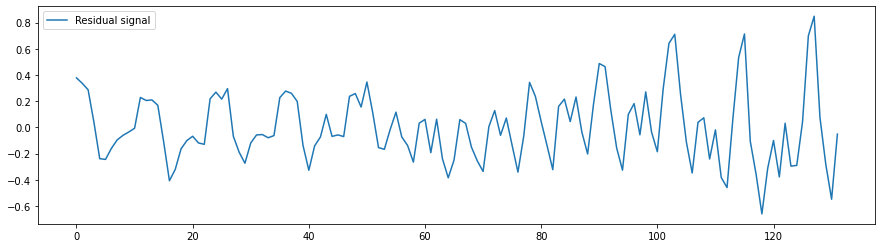

In [211]:
res_signal  = detrend_signal - estimated_regression_function(train_time_index)
fig, ax = fig_ax()
ax.plot(train_time_index ,res_signal, label="Residual signal")
_ = plt.legend()

In [212]:
# Now in order to duplicate the same processing to the test data, we are going to define a process function

def process(time_index):
    y = air_passengers_np[time_index]
    y_fit = np.polyval(coeffs, time_index)
    y = y - y_fit - estimated_regression_function(time_index)
    return y

In [250]:
# Now let's define final_data that will contain the final data processed 
final_data = air_passengers.copy()
final_data['Passengers'] = np.concatenate([res_signal, process(test_time_index)])

### Now let's look for the best parameters for the p, q and d parameters 
#### The d parameter

In [214]:
# To do so, we are going to use the Augmented Dickey-Fuller (ADF) test 

# Determine the order of differencing
diff_order = 0
p_value = adfuller(res_signal)[1]
while p_value > 0.05:
    diff_order += 1
    res_signal = res_signal.diff().dropna()
    p_value = adfuller(res_signal)[1]

print("The order of differencing is:", diff_order)

The order of differencing is: 0


#### The p and q parameters:

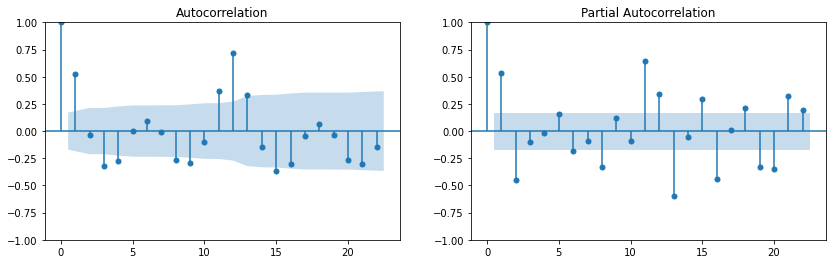

In [217]:
# Plot the ACF and PACF of the stationary differenced data

fig, ax = plt.subplots(1, 2, figsize = (14,4))
plot_acf(res_signal, ax=ax[0])
plot_pacf(res_signal, ax=ax[1])
plt.show()

In [218]:
# from these graphs we set the values of p and q as:
p,q = 14, 13
d = 0
# let's test this on our data
train_data = final_data[:splitting_time]
test_data = final_data[start_test_time:]

# Build ARIMA model

arima_model = ARIMA(train_data, order=(p,d, q))
arima_model_fit = arima_model.fit()

# Make predictions on test data
arima_preds = arima_model_fit.forecast(len(test_data))

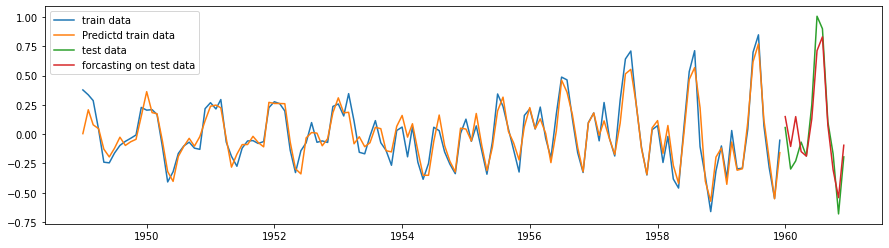

In [78]:
# let's plot the results 
fig, ax = fig_ax()

ax.plot(train_data, label="train data ")
ax.plot(arima_model_fit.predict(), label=f"Predictd train data")

ax.plot(test_data, label="test data")
ax.plot(arima_model_fit.forecast(len(test_data)), label=f"forcasting on test data")

_ = plt.legend()

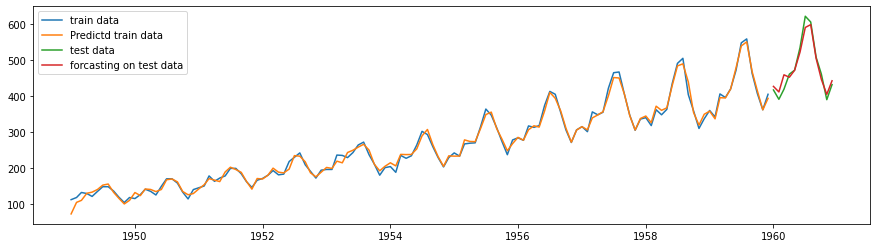

In [81]:
# Now let's plot the result on the original data 

def process_prediction(predictions, time_index):
    """
    A function to process the predictions by adding the trend and seasonal component 
    """
    y_fit = np.polyval(coeffs, time_index)
    predictions = predictions + y_fit + estimated_regression_function(time_index)
    temp = pd.DataFrame({'Passengers' : predictions.values})
    temp.set_index(predictions.index, inplace = True)
    temp['Passengers'] = scaler.inverse_transform(temp).squeeze()
    return temp

predictions_arima = process_prediction(arima_model_fit.forecast(len(test_data)), test_time_index)

fig, ax = fig_ax()

ax.plot(origine_air_passengers.iloc[:-12], label="train data ")
ax.plot(process_prediction(arima_model_fit.predict(), train_time_index), label=f"Predictd train data")

ax.plot(origine_air_passengers.iloc[-12:], label="test data")
ax.plot(predictions_arima, label=f"forcasting on test data")

_ = plt.legend()

### Model validation 

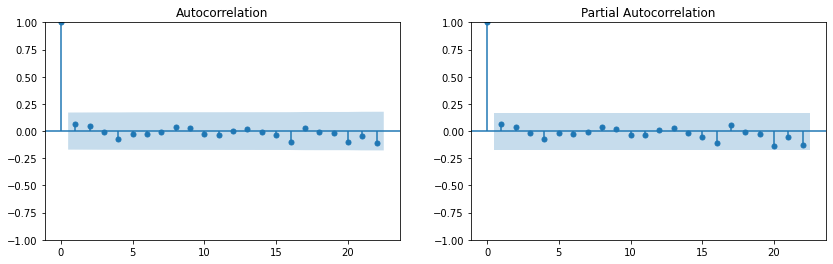

In [324]:
# A final step is to check if the resudials of the model are white noise 

fig, ax = plt.subplots(1, 2, figsize = (14,4))
plot_acf(arima_model_fit.resid, ax=ax[0])
plot_pacf(arima_model_fit.resid, ax=ax[1])
plt.show()

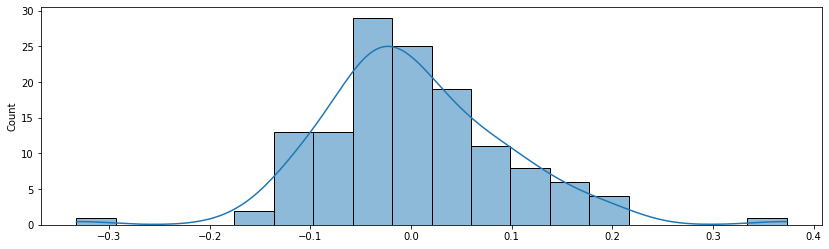

In [330]:
# Let's plot the distribution 
plt.figure(figsize=(14, 4))
import seaborn as sns
sns.histplot(arima_model_fit.resid, kde = True)
plt.show()

The first conclusion we can make is that the residuals of the fitted model are uncorrelated since we observe a spike only at log 0. Moreover, giving the distribution of the residuals we can also see that they are a realization of a normal distribution hence a white noise.

In [221]:
recap = pd.DataFrame({'mse training time':[mse(origine_air_passengers.iloc[:-12].values.squeeze(), process_prediction(arima_model_fit.predict(), train_time_index))] , 'mse testing time': [mse(origine_air_passengers.iloc[-12:], predictions_arima)]})

# The MLP model

In [304]:
# At first let's re-arange our data, we will use the p previous instances to predict the current one 
p = 13 # this value is inspired from the p value of the arima model
data = np.zeros((len(air_passengers) - p + 1, p+1))
for i in range(len(air_passengers) - p):
    data[i, :] = air_passengers.iloc[i:i+p+1].values.squeeze()
data = pd.DataFrame(data, columns=[f'time_{i}' for i in range(1,p+1) ] + ['target'] )
data = data.iloc[:-1]

In [252]:
# Now let's implement an appropriate DataLoader 

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data.iloc[index].values[:-1]
        y = self.data.iloc[index].values[-1]
        return x, y

# Now let's define the MLP model architecture
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [253]:
# Define the hyperparameters
input_dim = p  # number of previous instances to use as input
hidden_dim = 10
output_dim = 1
num_epochs = 30
learning_rate = 0.01
batch_size = 5

# As in the previous setting let's leave the last n_samples_pred = 12 samples for forcasting
data_train = data.iloc[:-12]
data_test = data.iloc[-12:]

data_train = TimeSeriesDataset(data_train)
trainloader = DataLoader(data_train, batch_size=batch_size, shuffle=False)

#data_test = TimeSeriesDataset(data_test)
# testloader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [237]:
# Now let's create the model and train it 
model = MLP(input_dim , hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    tot_loss = 0
    n_samples = 0
    for i, (inputs, targets) in enumerate(data_train):
    
        inputs = torch.from_numpy(inputs).float() # Convert numpy array to PyTorch tensor
        targets = torch.from_numpy(targets.reshape(-1,1)).float() # Convert numpy array to PyTorch tensor
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        tot_loss += loss.item()
        n_samples += len(targets)
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, tot_loss / n_samples))

Epoch [5/30], Loss: 0.0420
Epoch [10/30], Loss: 0.0476
Epoch [15/30], Loss: 0.0423
Epoch [20/30], Loss: 0.0308
Epoch [25/30], Loss: 0.0258
Epoch [30/30], Loss: 0.0276


In [238]:
# Now let's evaluate the model 
# Evaluate the model
model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(data.values[:,:-1]).float()
    outputs = model(inputs)
    predicted = outputs.data.numpy()

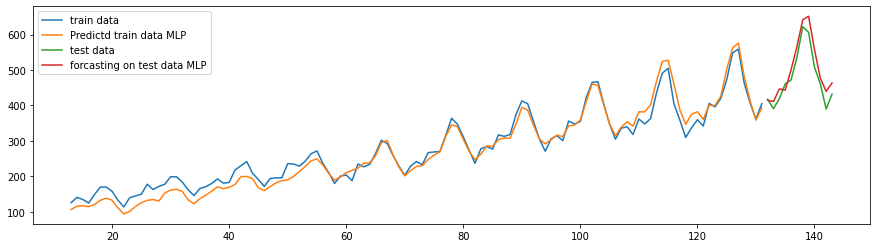

In [239]:
# let's plot the results 
fig, ax = fig_ax()

ax.plot(train_time_index[p:], origine_air_passengers['Passengers'].values[p:-12], label="train data ")
ax.plot(train_time_index[p:], scaler.inverse_transform(predicted).squeeze()[:-12], label=f"Predictd train data MLP")

ax.plot(test_time_index, origine_air_passengers['Passengers'].values[-12:], label="test data")
ax.plot(test_time_index, scaler.inverse_transform(predicted).squeeze()[-12:], label=f"forcasting on test data MLP")

_ = plt.legend()

In [240]:
recap.loc[-1] = [mse(origine_air_passengers['Passengers'].values[p:-12],scaler.inverse_transform(predicted).squeeze()[:-12] ), mse(origine_air_passengers['Passengers'].values[-12:],  scaler.inverse_transform(predicted).squeeze()[-12:])]
recap.reset_index(drop = True , inplace= True)

In [244]:
recap

,mse training time,mse testing time
0,93.575690,328.354831
1,458.710924,992.071163


# Now let's predict using LSTM 

In [305]:
data_train = data.iloc[:-12].values
data_test = data.iloc[-12:].values

train_X, train_y = data_train[:, :-1], data_train[:, -1]
test_X, test_y = data_test[:, :-1], data_test[:, -1]

# Reshape input data to be 3-dimensional for LSTM model
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [307]:
# As suggested in the paper we should fine tune the recurrent_dropout hyperparameter
mses = {'model': [],'mse training time': [], 'mse testing time': []}
for recurrent_dropout in np.linspace(0, 0.99, 10):
    model = Sequential()
    model.add(LSTM(50, activation='relu', recurrent_dropout= recurrent_dropout, input_shape=(p, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    model.fit(train_X, train_y, epochs=60, batch_size=5, verbose=0 )
    yhat = model.predict(test_X)
    train_mse = mse(origine_air_passengers['Passengers'].values[p:-12],  scaler.inverse_transform(model.predict(train_X)).squeeze())
    test_mse = mse(origine_air_passengers['Passengers'].values[-12:],  scaler.inverse_transform(yhat).squeeze())
    mses['model'].append(f'LSTM ({recurrent_dropout})')
    mses['mse training time'].append(train_mse)
    mses['mse testing time'].append(test_mse)

4/4 [==============================] - 0s 8ms/step


In [308]:
mses

{'model': ['LSTM (0.0)',
  'LSTM (0.11)',
  'LSTM (0.22)',
  'LSTM (0.33)',
  'LSTM (0.44)',
  'LSTM (0.55)',
  'LSTM (0.66)',
  'LSTM (0.77)',
  'LSTM (0.88)',
  'LSTM (0.99)'],
 'mse training time': [505.24095768044987,
  370.46726278163504,
  403.35612610214537,
  418.9204197706378,
  562.3274915575196,
  621.2276054580594,
  978.2749123157593,
  1021.4247688180943,
  1573.6311548146607,
  3248.745604128299],
 'mse testing time': [4330.269183557636,
  621.2840467062002,
  940.7999611231498,
  724.8512153624712,
  1337.7541764596633,
  1596.3860039110295,
  2365.832470792268,
  2448.058582632259,
  4201.62596976175,
  8692.591648674725]}

In [309]:
# It looks like in our case the best recurrent_dropout is 0.11

model = Sequential()
model.add(LSTM(50, activation='relu', recurrent_dropout=0.11, input_shape=(p, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
history = model.fit(train_X, train_y, epochs=60, batch_size=5, verbose=2)

Epoch 1/60
24/24 - 3s - loss: 0.7275 - 3s/epoch - 137ms/step
Epoch 2/60
24/24 - 0s - loss: 0.4887 - 400ms/epoch - 17ms/step
Epoch 3/60
24/24 - 0s - loss: 0.4074 - 400ms/epoch - 17ms/step
Epoch 4/60
24/24 - 0s - loss: 0.3374 - 379ms/epoch - 16ms/step
Epoch 5/60
24/24 - 0s - loss: 0.1824 - 386ms/epoch - 16ms/step
Epoch 6/60
24/24 - 0s - loss: 0.1505 - 415ms/epoch - 17ms/step
Epoch 7/60
24/24 - 0s - loss: 0.1415 - 339ms/epoch - 14ms/step
Epoch 8/60
24/24 - 0s - loss: 0.1464 - 372ms/epoch - 16ms/step
Epoch 9/60
24/24 - 0s - loss: 0.1471 - 356ms/epoch - 15ms/step
Epoch 10/60
24/24 - 0s - loss: 0.1117 - 346ms/epoch - 14ms/step
Epoch 11/60
24/24 - 0s - loss: 0.1458 - 367ms/epoch - 15ms/step
Epoch 12/60
24/24 - 0s - loss: 0.1082 - 339ms/epoch - 14ms/step
Epoch 13/60
24/24 - 0s - loss: 0.1243 - 289ms/epoch - 12ms/step
Epoch 14/60
24/24 - 0s - loss: 0.1028 - 290ms/epoch - 12ms/step
Epoch 15/60
24/24 - 0s - loss: 0.1013 - 360ms/epoch - 15ms/step
Epoch 16/60
24/24 - 0s - loss: 0.1008 - 352ms/epoch

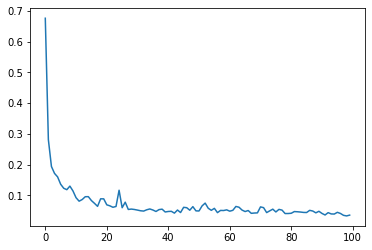

In [292]:
plt.plot(history.history['loss'])

5/5 [==============================] - 2s 27ms/step


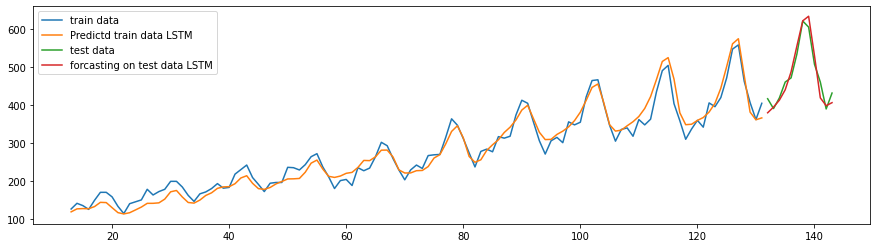

In [151]:
yhat = model.predict(data.values[:,:-1].reshape(data.shape[0], data.shape[1] -1 , 1))

# let's plot the results 
fig, ax = fig_ax()

ax.plot(train_time_index[p:], origine_air_passengers['Passengers'].values[p:-12], label="train data ")
ax.plot(train_time_index[p:], scaler.inverse_transform(yhat).squeeze()[:-12], label=f"Predictd train data LSTM")

ax.plot(test_time_index, origine_air_passengers['Passengers'].values[-12:], label="test data")
ax.plot(test_time_index, scaler.inverse_transform(yhat).squeeze()[-12:], label=f"forcasting on test data LSTM")

_ = plt.legend()

In [298]:
recap.loc[-1] = [mse(origine_air_passengers['Passengers'].values[p:-12],scaler.inverse_transform(yhat).squeeze()[:-12] ), mse(origine_air_passengers['Passengers'].values[-12:],  scaler.inverse_transform(yhat).squeeze()[-12:])]
recap.reset_index(drop = True , inplace= True)

In [320]:
recap.insert(0, 'model',['ARIMA', 'MLP'])
pd.concat([recap, pd.DataFrame(mses)], axis = 0)

,model,mse training time,mse testing time
0,ARIMA,93.575690,328.354831
1,MLP,458.710924,992.071163
0,LSTM (0.0),505.240958,4330.269184
1,LSTM (0.11),370.467263,621.284047
2,LSTM (0.22),403.356126,940.799961
3,LSTM (0.33),418.920420,724.851215
4,LSTM (0.44),562.327492,1337.754176
5,LSTM (0.55),621.227605,1596.386004
6,LSTM (0.66),978.274912,2365.832471
7,LSTM (0.77),1021.424769,2448.058583


* **Conclusion :** The found results are coherent with the content of the research paper.